# Noisy logistic map
We study the noisy logistic map, a non-linear dynamical system defined by the recursive relation $x_{t + 1} = (4x_{t}(1 - x_{t}) + \xi_{t}) \mod 1$ over the state space $\mathcal{X} = [0 , 1]$. Here, $\xi_{t}$ is i.i.d. additive _trigonometric_ noise as defined in~\cite{Ostruszka2000}. The probability distribution of trigonometric noise is supported in $[-0.5,0.5]$ and is proportional to $\cos^{N}(\pi\xi)$, $N$ being an {\em even} integer. In this setting, the true invariant distribution, transition kernel and Koopman eigenvalues are easily computed. 


In Tab.~\ref{tab:logistic_map_results} we compare the performance of KRR, PCR and RRR (see Sec.~\ref{sec:erm}) trained with a Gaussian kernel. We average over 100 different training datasets each containing $10^{4}$ data points and evaluate the test error on 500 unseen points. In Tab.~\ref{tab:logistic_map_results} we show the approximation error for the three largest eigenvalues of the Koopman operator, $\lambda_{1} = 1$ and $\lambda_{2,3} = -0.193 \pm 0.191i$ as well as training and test errors. The following eigenvalues $|\lambda_{4,5}| \approx 0.027$ are an order of magnitude smaller than $|\lambda_{2,3}|$.  Both PCR and RRR have been trained with the rank constraint $r=3$. The regularization parameter $\gamma$ for KRR and RRR is the value $\gamma \in [10^{-7}, 1]$ minimizing the validation error. The RRR estimator always outperforms PCR, and in the estimation of the non-trivial eigenvalues $\lambda_{2,3}$ ($\lambda_{1}$ corresponding to the equilibrium mode is well approximated by every estimator) attains the best results. In Fig.~\ref{fig:uniform_bound_logistic} we report the results of a comparison between PCR and RRR performed under Ivanov regularization. This experiment was designed to empirically test the uniform bounds presented in Sec.~\ref{sec:bounds}. Again, RRR consistently outperforms the PCR estimator.

### Getting the data

In [26]:
import numpy as np
import scipy.linalg
import kooplearn
#import logginguull
from sklearn.gaussian_process.kernels import RBF
from kooplearn.data.datasets.stochastic import LogisticMap
#logging.basicConfig(level=logging.INFO)

map = LogisticMap(N = 20, rng_seed = 0) #Setting rng_seed for reproducibility
dataset = map.generate(X0 = np.array([0.5]), T = 10000)

#Splitting the trajectory into inputs and outputs
X = dataset[:-1]
Y = dataset[1:]

### Extended DMD with polynomials
[... let ChatGPT write this ...]

In [3]:
#Subclassing kooplearn.abc.FeatureMap
class PolyFeatures(kooplearn.abc.FeatureMap):
    def __init__(self, order: int = 10) -> None:
        super().__init__()
        self.order = order
    
    def __call__(self, X: np.ndarray) -> np.ndarray:
        return np.concatenate([X**i for i in range(0, self.order )], axis=1)
#Instantiating the feature map
feature_map = PolyFeatures(order = 100)
#print(feature_map(X)[:5])

### Running the model

In [4]:
edmd = kooplearn.ExtendedDMD(feature_map = feature_map, reduced_rank= True, rank = 5, tikhonov_reg=1e-5)
edmd.fit(X, Y)

In [126]:
kdmd = kooplearn.KernelDMD(kernel = RBF(length_scale=0.5), rank = 26, tikhonov_reg=1e-5, svd_solver='randomized', iterated_power = 1,
    n_oversamples = 3)
kdmd.fit(X, Y)

In [12]:
kdmd = kooplearn.KernelDMD(kernel = RBF(length_scale=0.5), rank = 8, tikhonov_reg=1e-5, svd_solver='arnoldi')
kdmd.fit(X, Y)

Arnoldi vs randomized is failing: 

N = 60

kdmd = kooplearn.KernelDMD(kernel = RBF(length_scale=0.5), rank = 10, tikhonov_reg=1e-5, svd_solver='randomized')

Normalization in kooplearn/_src/operator_regression/dual.py:292 and line 297 is not good... maybe use "< machine precison" instead of == 0.

Code fails: 

kdmd_PCR = kooplearn.KernelDMD(kernel = RBF(length_scale=0.5), reduced_rank=False, rank = 3, tikhonov_reg=1e-5, svd_solver='randomized')

kdmd_PCR.fit(X, Y)

In [16]:
kdmd_PCR = kooplearn.KernelDMD(kernel = RBF(length_scale=0.5), reduced_rank=False, rank = 3, tikhonov_reg=1e-5, svd_solver='randomized')
kdmd_PCR.fit(X, Y)

TypeError: regularize() missing 1 required positional argument: 'reg'

### Plotting the results

In [7]:
import matplotlib.pyplot as plt
spectral_error = lambda estim :  scipy.spatial.distance.directed_hausdorff(estim.eig().view("(2,)float"), map._evals.view("(2,)float"))[0]
def compare_eig_plots(models: list):
    _, ax = plt.subplots()
    for _model_dict in models:
        model = _model_dict.pop('model')
        if spectral_error(model)>0.:
            _model_dict['label'] += f"({spectral_error(model):.2e})"
        ax.scatter(model.eig().real, model.eig().imag,  **_model_dict)
        
    #Add the unit circle
    circ = plt.Circle((0, 0), radius=1, linestyle='--', edgecolor='k', facecolor='None')
    ax.add_patch(circ)
    #Set the axes to be equal
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('Real')
    ax.set_ylabel('Imaginary')
    ax.legend()

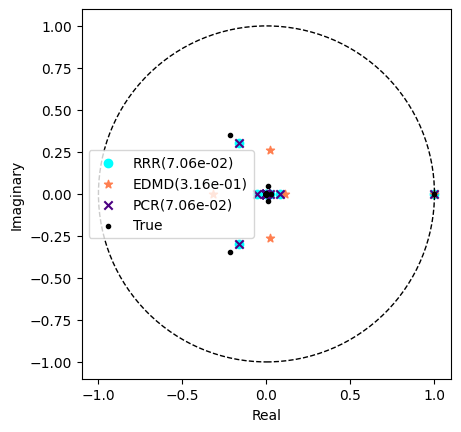

In [14]:
models = [
    {
        'model': kdmd,
        'label': 'RRR',
        'marker': 'o',
        'c': 'aqua',
    },
    {
        'model': edmd,
        'label': 'EDMD',
        'marker': '*',
        'c': 'coral',
    },
    {
        'model': kdmd_PCR,
        'label': 'PCR',
        'marker': 'x',
        'c': 'indigo',
    },
    {
        'model': map,
        'label': 'True',
        'marker': '.',
        'c': 'k',
    },
]
compare_eig_plots(models)

In [15]:
kdmd.eig()

array([-0.16477558-0.30048211j, -0.16477558+0.30048211j,
       -0.05434597+0.j        , -0.00512807+0.j        ,
        0.        +0.j        ,  0.01886948+0.j        ,
        0.08019764+0.j        ,  0.99997963+0.j        ])

In [11]:
kdmd_PCR.eig()

array([-1.64765229e-01-3.00488434e-01j, -1.64765229e-01+3.00488434e-01j,
       -5.45138999e-02+0.00000000e+00j, -4.97740804e-03+0.00000000e+00j,
       -2.60019468e-05+0.00000000e+00j, -1.83785501e-08+0.00000000e+00j,
       -3.78554647e-11+0.00000000e+00j, -9.11624712e-12+0.00000000e+00j,
       -5.25114691e-14+0.00000000e+00j, -1.60944377e-14-2.66599794e-14j,
       -1.60944377e-14+2.66599794e-14j, -1.09710290e-14+0.00000000e+00j,
       -5.23421234e-15+0.00000000e+00j, -2.27162611e-15-5.55007207e-15j,
       -2.27162611e-15+5.55007207e-15j,  1.47836151e-15-1.33952839e-14j,
        1.47836151e-15+1.33952839e-14j,  8.63031011e-15+0.00000000e+00j,
        1.58170432e-14-1.64843977e-14j,  1.58170432e-14+1.64843977e-14j,
        2.08144569e-14+0.00000000e+00j,  1.51351609e-09+0.00000000e+00j,
        2.23242670e-05+0.00000000e+00j,  1.88515144e-02+0.00000000e+00j,
        8.02220858e-02+0.00000000e+00j,  9.99979627e-01+0.00000000e+00j])

In [23]:
map._evals

array([ 1.00000000e+00+0.00000000e+00j, -2.28279663e-01+3.75520402e-01j,
       -2.28279663e-01-3.75520402e-01j,  3.19802627e-02+6.88143012e-02j,
        3.19802627e-02-6.88143012e-02j, -2.65794689e-02+0.00000000e+00j,
        2.21140923e-02+0.00000000e+00j,  8.17906072e-04+1.78078306e-03j,
        8.17906072e-04-1.78078306e-03j,  6.68545262e-04+0.00000000e+00j,
       -3.75924677e-05+8.41894467e-05j, -3.75924677e-05-8.41894467e-05j,
        2.68124002e-05+0.00000000e+00j, -1.09438692e-05+0.00000000e+00j,
        6.56536370e-06+0.00000000e+00j, -5.64796701e-07+3.07977948e-06j,
       -5.64796701e-07-3.07977948e-06j, -2.15563098e-06+0.00000000e+00j,
        6.18678647e-07+8.27619610e-07j,  6.18678647e-07-8.27619610e-07j,
        5.48535273e-07+0.00000000e+00j, -1.74441488e-07+3.12628737e-07j,
       -1.74441488e-07-3.12628737e-07j,  6.80476317e-08+6.48508491e-08j,
        6.80476317e-08-6.48508491e-08j, -2.35023075e-08+5.33801354e-08j,
       -2.35023075e-08-5.33801354e-08j, -3.17312639

In [125]:
scipy.linalg.svdvals(map._A)

array([1.43826531e+00, 9.60515348e-01, 8.01627015e-01, 6.53785038e-01,
       5.98457099e-01, 4.03508883e-01, 3.35253045e-01, 1.94267923e-01,
       1.45082964e-01, 7.31652606e-02, 4.91008404e-02, 2.14902153e-02,
       1.29306887e-02, 4.87895264e-03, 2.61545439e-03, 8.42201369e-04,
       3.97642170e-04, 1.07613711e-04, 4.39286510e-05, 9.75123293e-06,
       3.33715570e-06, 5.82539659e-07, 1.57782315e-07, 1.98486966e-08,
       3.68901271e-09, 2.49097668e-10, 2.99753329e-16, 5.13342027e-17,
       4.68666370e-17, 3.66406500e-17, 2.19670992e-17, 1.58104948e-17,
       1.26882223e-17, 1.11124093e-17, 1.04214748e-17, 8.73964486e-18,
       8.22791296e-18, 6.88976775e-18, 6.45220759e-18, 6.07004967e-18,
       4.94419735e-18, 4.67760191e-18, 3.47712988e-18, 2.68537759e-18,
       2.17962585e-18, 1.86357190e-18, 1.80497855e-18, 1.15207759e-18,
       7.59428630e-19, 2.76907391e-19, 1.89317520e-19])

In [20]:
scipy.sparse.linalg.eigsh(kdmd.kernel_X,7,return_eigenvectors=False)

array([6.57258162e-01, 5.61179852e+00, 4.01616712e+01, 2.39185278e+02,
       1.04930802e+03, 3.22956051e+03, 5.43544341e+03])

In [24]:
n_grid = 200
_grid = np.linspace(-1.1, 1.1, n_grid)
real, imag = np.meshgrid(_grid, _grid)
z_list = real.flatten() + 1j * imag.flatten()
vals = [np.min(scipy.linalg.svdvals(map._A - z*np.eye(*map._A.shape))) for z in z_list]
vals = np.array(vals).reshape(n_grid, n_grid)

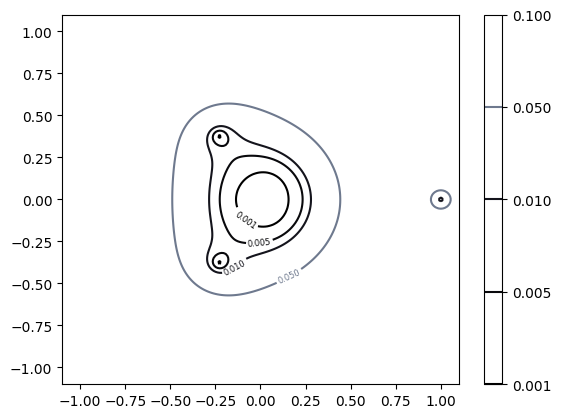

In [25]:
from matplotlib import ticker
fig, ax = plt.subplots()
CS = ax.contour(real, imag, vals, levels = [1e-3, 5e-3, 1e-2, 5e-2, 1e-1], cmap='bone')
ax.clabel(CS, inline=True, fontsize=6)
plt.colorbar(CS)


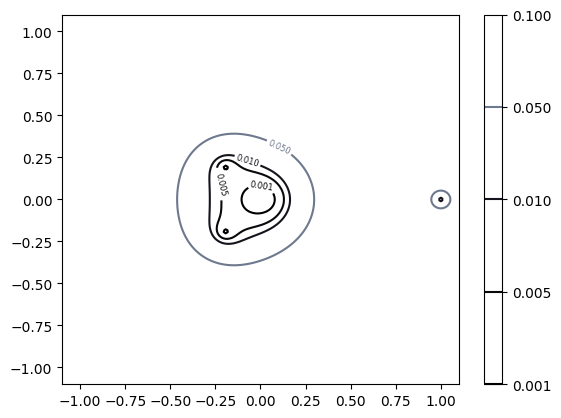

In [27]:
n_grid = 200
_grid = np.linspace(-1.1, 1.1, n_grid)
real, imag = np.meshgrid(_grid, _grid)
z_list = real.flatten() + 1j * imag.flatten()
vals = [np.min(scipy.linalg.svdvals(map._A - z*np.eye(*map._A.shape))) for z in z_list]
vals = np.array(vals).reshape(n_grid, n_grid)
from matplotlib import ticker
fig, ax = plt.subplots()
CS = ax.contour(real, imag, vals, levels = [1e-3, 5e-3, 1e-2, 5e-2, 1e-1], cmap='bone')
ax.clabel(CS, inline=True, fontsize=6)
plt.colorbar(CS)


In [45]:
from kooplearn._src.dashboard.visualizer import Visualizer

In [46]:
vis = Visualizer(kdmd_PCR)

fig = vis.plot_eigs()
fig.show()

fig = vis.plot_freqs()
fig.show()

fig = vis.plot_modes()
fig.show()

AttributeError: 'KernelDMD' object has no attribute 'X_fit_'